In [ ]:
!pip install tensorflow==2.10.1

In [ ]:
!pip install n2v

In [ ]:
import tensorflow as tf
import n2v
print(tf.__version__)
#print(n2v.__version__)

2.10.1


In [ ]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()

In [ ]:
#METHOD 1: Loading images using load_imgs_from_directory method
# We load all the '.png' files from the directory.
# The function will return a list of images (numpy arrays).

imgs = datagen.load_imgs_from_directory(directory = "Downloads/",
                                        filter='longbeachNoise*.png',dims='XYC')  #ZYX for 3D

print(len(imgs)) #need to check if function actually got the image

# Let's look at the shape of the image
print('shape of loaded images: ',imgs[0].shape)
# If the image has four color channels (stored in the last dimension): RGB and Aplha.
# We are not interested in Alpha and will get rid of it.
imgs[0] = imgs[0][...,:3]
print('shape without alpha:    ',imgs[0].shape)
print('The data type of the first image is: ', imgs[0].dtype)


1
shape of loaded images:  (1, 2526, 1479, 4)
shape without alpha:     (1, 2526, 1479, 3)
The data type of the first image is:  float32


In [ ]:
print(len(imgs))
print(imgs[0].shape)
print(imgs[0].dtype)

1
(1, 2526, 1479, 3)
float32


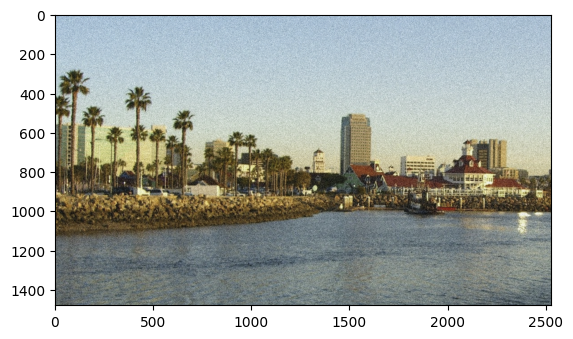

In [ ]:
# Let's look at the image.
plt.figure()
plt.imshow(np.rot90(imgs[0][0,:,:,:], k=-1))
plt.show()

In [ ]:
patch_size = 64

In [ ]:
# Patches are extracted from all images and combined into a single numpy array
patch_shape = (patch_size,patch_size)
patches = datagen.generate_patches_from_list(imgs, shape=patch_shape)


Generated patches: (7176, 64, 64, 3)


In [ ]:
# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.
train_val_split = int(patches.shape[0] * 0.8)
X = patches[:train_val_split]
X_val = patches[train_val_split:]

In [ ]:
print(X.shape)
print(X.dtype)
print(X_val.shape)

(5740, 64, 64, 3)
float32
(1436, 64, 64, 3)


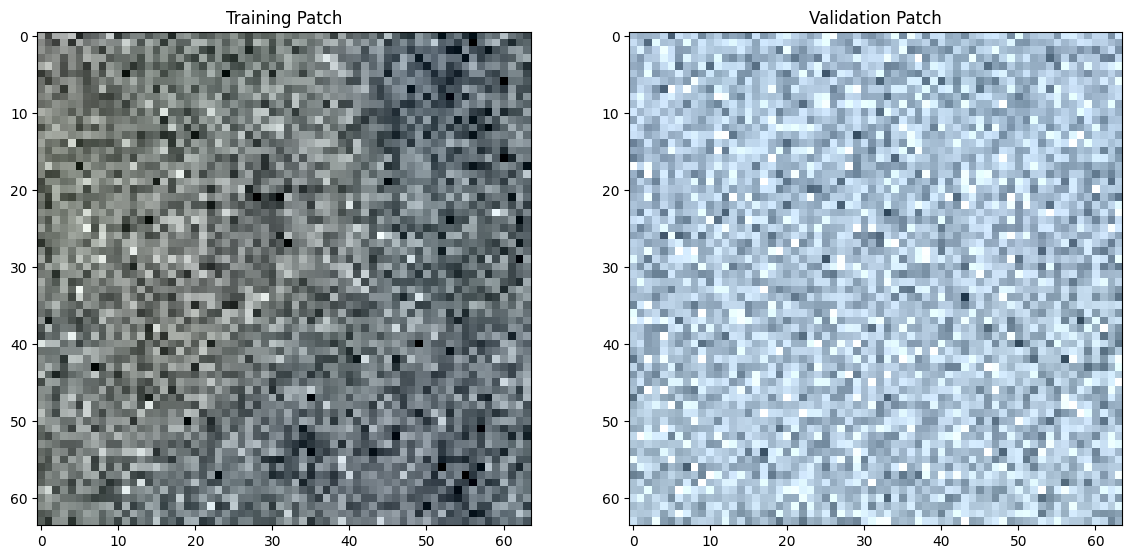

In [ ]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...])
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...])
plt.title('Validation Patch');

In [ ]:
# train_steps_per_epoch is set to (number of training patches)/(batch size), like this each training patch
# is shown once per epoch.
train_batch = 32
config = N2VConfig(X, unet_kern_size=3,
                   unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/train_batch), train_epochs=50, train_loss='mse',
                   batch_norm=True, train_batch_size=train_batch, n2v_perc_pix=0.198, n2v_patch_shape=(patch_size, patch_size),
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, single_net_per_channel=False)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['0.57240516', '0.5965473', '0.56930244'],
 'stds': ['0.23796807', '0.25653973', '0.28345105'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 3,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 3),
 'train_loss': 'mse',
 'train_epochs': 50,
 'train_steps_per_epoch': 179,
 'train_learning_rate': 0.0004,
 'train_batch_size': 32,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': False,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [ ]:
# a name used to identify the model
model_name = 'n2v_2D_RGB'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

C:\Users\bhana\anaconda3\envs\test\n2v\n2v\models\n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: C:\Users\bhana\models\n2v_2D_RGB
  warnings.warn(


In [ ]:
# We are ready to start training now.
history = model.train(X, X_val)

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████████████████████████████████████████████| 1436/1436 [00:02<00:00, 652.36it/s]


Epoch 1/50
179/179 [==============================] - 33s 170ms/step - loss: 0.1447 - n2v_mse: 0.1447 - n2v_abs: 0.2637 - val_loss: 0.4880 - val_n2v_mse: 0.4878 - val_n2v_abs: 0.5643 - lr: 4.0000e-04
Epoch 2/50
179/179 [==============================] - 30s 170ms/step - loss: 0.0414 - n2v_mse: 0.0414 - n2v_abs: 0.1567 - val_loss: 0.4654 - val_n2v_mse: 0.4652 - val_n2v_abs: 0.5462 - lr: 4.0000e-04
Epoch 3/50
179/179 [==============================] - 32s 176ms/step - loss: 0.0278 - n2v_mse: 0.0278 - n2v_abs: 0.1264 - val_loss: 0.4962 - val_n2v_mse: 0.4960 - val_n2v_abs: 0.5604 - lr: 4.0000e-04
Epoch 4/50
179/179 [==============================] - 31s 172ms/step - loss: 0.0208 - n2v_mse: 0.0208 - n2v_abs: 0.1093 - val_loss: 0.5212 - val_n2v_mse: 0.5211 - val_n2v_abs: 0.5736 - lr: 4.0000e-04
Epoch 5/50
179/179 [==============================] - 30s 170ms/step - loss: 0.0177 - n2v_mse: 0.0177 - n2v_abs: 0.1005 - val_loss: 0.5232 - val_n2v_mse: 0.5231 - val_n2v_abs: 0.5749 - lr: 4.0000e-04


['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


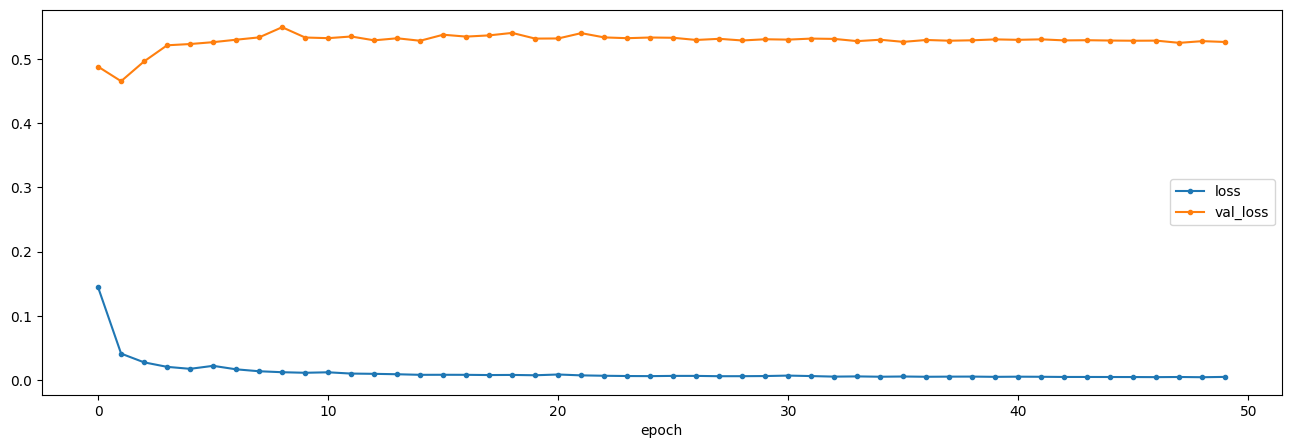

In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

In [ ]:
# We import all our dependencies.
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import imread, imsave
from csbdeep.io import save_tiff_imagej_compatible

In [ ]:
# A previously trained model is loaded by creating a new N2V-object without providing a 'config'.
model_name = 'n2v_2D_RGB'
basedir = 'models'
model = N2V(config=None, name=model_name, basedir=basedir)

Loading network weights from 'weights_best.h5'.


In [ ]:
# We load the data we want to process.
img = imread('Downloads/longbeachNoise.png')
print(img.dtype)
img = img[...,:3]
print(img.shape)

float32
(1479, 2526, 3)


In [ ]:

# Here we denoise the image (predict)
# The parameter 'n_tiles' can be used if images are to big for the GPU memory.
# If we do not provide the n_tiles' parameter the system will automatically try to find an appropriate tiling.
# This can take longer.
pred = model.predict(img, axes='YXC')



Out of memory, retrying with n_tiles = (1, 2, 1)
Out of memory, retrying with n_tiles = (2, 2, 1)
Out of memory, retrying with n_tiles = (2, 4, 1)
1/1 [==============================] - 1s 1s/step


 12%|███████████▌                                                                                | 1/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


 25%|█████████████████████                                                               | 2/8 [00:00<00:01,  5.99it/s]

1/1 [==============================] - 0s 58ms/step


 38%|███████████████████████████████▌                                                    | 3/8 [00:00<00:01,  4.11it/s]

1/1 [==============================] - 0s 53ms/step


 50%|██████████████████████████████████████████                                          | 4/8 [00:01<00:01,  3.48it/s]

1/1 [==============================] - 0s 59ms/step


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:01<00:00,  3.16it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:01<00:00,  3.07it/s]

1/1 [==============================] - 0s 53ms/step


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:02<00:00,  3.02it/s]

1/1 [==============================] - 0s 59ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.21it/s]


In [ ]:
pred.shape

(1479, 2526, 3)

In [ ]:
# model.load_weights('weights_last.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10347623..1.1436329].


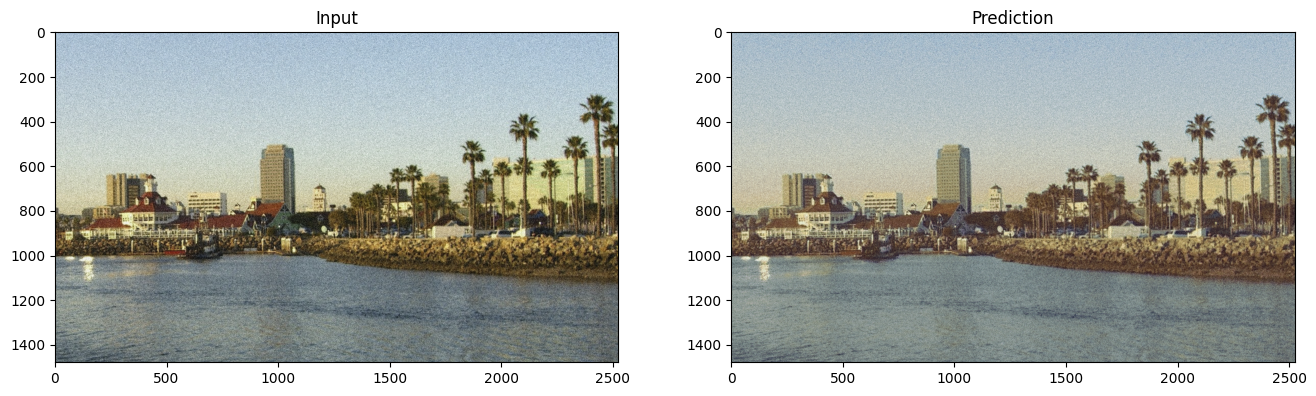

In [ ]:
# Let's look at the results.
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(pred)
plt.title('Prediction');

In [ ]:

import math
gt = imread('Downloads/longbeach.png') #ground truth

def PSNR(gt, img):
    mse = np.mean(np.square(gt - img))
    return 20 * np.log10(255) - 10 * np.log10(mse) #255-> 1

psnr_value = PSNR(gt[:,:,:3], pred)
print("PSNR:", psnr_value)
#subtract 45

PSNR: 66.32209589459829


In [ ]:
save_tiff_imagej_compatible('pred_train_longbeach1.tif', pred, axes='YXC')